In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os  

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
DIRECTORY = r"D:\Face-Mask-Detection AIB\dataset"
CATEGORIES = ["with_mask", "without_mask"]
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

[INFO] loading images...


C:\Users\elmostafa\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [3]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [4]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [5]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\elmostafa\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
95/95 [==============================] - 330s 3s/step - loss: 0.5824 - acc: 0.6928 - val_loss: 0.3835 - val_acc: 0.8279
Epoch 2/20
95/95 [==============================] - 317s 3s/step - loss: 0.3200 - acc: 0.8797 - val_loss: 0.2936 - val_acc: 0.8605
Epoch 3/20
95/95 [==============================] - 305s 3s/step - loss: 0.2430 - acc: 0.9077 - val_loss: 0.4420 - val_acc: 0.8214
Epoch 4/20
95/95 [==============================] - 303s 3s/step - loss: 0.2065 - acc: 0.9199 - val_loss: 0.2852 - val_acc: 0.8761
Epoch 5/20
95/95 [==============================] - 303s 3s/step - loss: 0.1815 - acc: 0.9318 - val_loss: 0.4270 - val_acc: 0.8501
Epoch 6/20
95/95 [==============================] - 304s 3s/step - loss: 0.1544 - acc: 0.9457 - val_loss: 0.3022 - val_acc: 0.8787
Epoch 7/20
95/95 [==============================] - 301s 3s/step - los

In [7]:
for l in model.layers:
    print(l.name,l.trainable)

input_1 False
Conv1_pad False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False

In [8]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


In [9]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.82      0.90       383
without_mask       0.85      0.99      0.91       384

    accuracy                           0.91       767
   macro avg       0.92      0.91      0.91       767
weighted avg       0.92      0.91      0.91       767



In [10]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


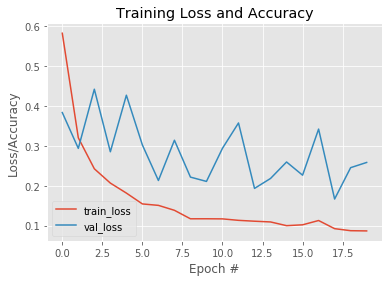

In [11]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot1.png")